In [5]:
import sys
sys.path.insert(0, '../../')

In [6]:
import graph
import importlib
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
import schedule as sch
import topo
import typing
import utils
import yaml
from tqdm.notebook import tqdm

matplotlib.rc('font', family='Times New Roman', size=16)

In [7]:
def unit_size_cb(r: int):
    return 10000 * math.pow(10, random.randint(0, 1))

def gen_graphs(graph_count, source_selector_dict):
    source_selector = graph.SourceSelector(source_selector_dict)
    gen_args_list = [
            {
            "total_rank": random.randint(3, 7),
            "max_node_per_rank": random.randint(1, 3),
            "max_predecessors": random.randint(1, 2),
            "mi_cb": lambda: 1,
            "memory_cb": lambda: int(2e8),
            "unit_size_cb": unit_size_cb,
            "unit_rate_cb": lambda: random.randint(10, 20),
            "source_hosts": source_selector,
            "sink_hosts": ["cloud1"],
        }
        for _ in range(graph_count)
    ]
    return [
        graph.GraphGenerator("g" + str(idx), **gen_args).gen_dag_graph()
        for idx, gen_args in enumerate(gen_args_list)
    ]

In [8]:
def big_avg(array):
    return sum(array) / len(array)

In [9]:
from tqdm.notebook import trange

def run(sc, labels, source_selector_dict):
    flow_bp_data = [[] for _ in labels]
    all_cloud_bp_data = [[] for _ in labels]
    sbon_bp_data = [[] for _ in labels]
    flow_event_data = [[] for _ in labels]
    all_cloud_event_data = [[] for _ in labels]
    sbon_event_data = [[] for _ in labels]
    edge_random_event_data = [[] for _ in labels]
    test_round = 10
    for idx, graph_count in enumerate(labels):
        for _ in trange(test_round, desc="running with {} graphs".format(graph_count)):
            graph_list = gen_graphs(graph_count, source_selector_dict)
            sc.topo.clear_occupied()
            flow_scheduler = sch.FlowScheduler(sc)
            flow_calculator = sch.LatencyCalculator(sc.topo)
            flow_result_list = flow_scheduler.schedule_multiple(graph_list)
            for g, result in zip(graph_list, flow_result_list):
                assert result is not None
                flow_calculator.add_scheduled_graph(g, result)
            flow_latency, flow_bp, _ = flow_calculator.compute_latency()
            for g in graph_list:
                flow_event_data[idx].append(flow_latency[g.uuid] / g.number_of_vertices())
                flow_bp_data[idx].append(flow_bp[g.uuid])
            # flow_event_data[idx].extend()

            sc.topo.clear_occupied()
            sbon_scheduler = sch.SBONScheduler(sc)
            sbon_calculator = sch.LatencyCalculator(sc.topo)
            sbon_result_list = sbon_scheduler.schedule_multiple(graph_list)
            for g, result in zip(graph_list, sbon_result_list):
                assert result is not None
                sbon_calculator.add_scheduled_graph(g, result)
            sbon_latency, sbon_bp, _ = sbon_calculator.compute_latency()
            for g in graph_list:
                sbon_event_data[idx].append(sbon_latency[g.uuid] / g.number_of_vertices())
                sbon_bp_data[idx].append(sbon_bp[g.uuid])

            sc.topo.clear_occupied()
            all_cloud_scheduler = sch.AllCloudScheduler(sc)
            all_cloud_calculator = sch.LatencyCalculator(sc.topo)
            all_cloud_result_list = all_cloud_scheduler.schedule_multiple(graph_list)
            for g, result in zip(graph_list, all_cloud_result_list):
                assert result is not None
                all_cloud_calculator.add_scheduled_graph(g, result)
            all_cloud_latency, all_cloud_bp, _ = all_cloud_calculator.compute_latency()
            for g in graph_list:
                all_cloud_event_data[idx].append(all_cloud_latency[g.uuid] / g.number_of_vertices())
                all_cloud_bp_data[idx].append(all_cloud_bp[g.uuid])
            # all_cloud_event_data[idx].extend(list(all_cloud_latency.values()))

            # sc.topo.clear_occupied()
            # edge_random_scheduler = sch.EdgeRandomScheduler(sc)
            # edge_random_calculator = sch.LatencyCalculator(sc.topo)
            # edge_random_result_list = edge_random_scheduler.schedule_multiple(graph_list)
            # for g, result in zip(graph_list, edge_random_result_list):
            #     assert result is not None
            #     edge_random_calculator.add_scheduled_graph(g, result)
            # edge_random_latency, edge_random_bp = edge_random_calculator.compute_latency()
            # edge_random_event_data[idx].extend(list(edge_random_latency.values()))

            # for k in all_cloud_latency.keys():
                # flow_event_data[idx].append(flow_latency[k] / all_cloud_latency[k])
                # edge_random_event_data[idx].append(edge_random_latency[k] / flow_latency[k])
    flow_event_data = [big_avg(i) for i in flow_event_data]
    flow_bp_data = [big_avg(i) for i in flow_bp_data]
    all_cloud_event_data = [big_avg(i) for i in all_cloud_event_data]
    all_cloud_bp_data = [big_avg(i) for i in all_cloud_bp_data]
    sbon_event_data = [big_avg(i) for i in sbon_event_data]
    sbon_bp_data = [big_avg(i) for i in sbon_bp_data]
    return flow_event_data, flow_bp_data, all_cloud_event_data, all_cloud_bp_data, sbon_event_data, sbon_bp_data
    # ax_lat.plot(flow_event_data)
    # ax_lat.plot(all_cloud_event_data)
    # ax_bp.plot(flow_bp_data)
    # ax_bp.plot(all_cloud_bp_data)
    # plt.eventplot(flow_event_data, lineoffsets=[i-width for i in range(len(labels))], linelengths=width, linewidths=0.5, colors="C0", orientation="vertical")
    # plt.eventplot(edge_random_event_data, lineoffsets=[i for i in range(len(labels))], linelengths=width, linewidths=0.5, colors="C1", orientation="vertical")
    # plt.eventplot(all_cloud_event_data, lineoffsets=[i+width for i in range(len(labels))], linelengths=width, linewidths=0.5, colors="C2", orientation="vertical")
    # plt.violinplot(flow_event_data, vert=True, positions=[i-width for i in range(len(labels))], widths=width)
    # plt.violinplot(edge_random_event_data, vert=True, positions=[i for i in range(len(labels))], widths=width)
    # plt.violinplot(all_cloud_event_data, vert=True, positions=[i+width for i in range(len(labels))], widths=width)

In [10]:
sc = topo.Scenario.from_dict(yaml.load(open("../../samples/1e3h.yaml", "r").read(), Loader=yaml.Loader))
f_lat, f_bp, ac_lat, ac_bp, sbon_lat, sbon_bp = run(sc, [4, 8, 12, 16, 20], {'rasp1': 8, 'rasp2': 8, 'rasp3': 8})

sc2 = topo.Scenario.from_dict(yaml.load(open("../../samples/1e12h.yaml", "r").read(), Loader=yaml.Loader))
source_dict = {'rasp'+str(i): 8 for i in range(1, 7)}
source_dict.update({'vm'+str(i): 16 for i in range(1, 7)})
f_lat2, f_bp2, ac_lat2, ac_bp2, sbon_lat2, sbon_bp2 = run(sc2, [40, 60, 80, 100, 120], source_dict)

sc3 = topo.Scenario.from_dict(yaml.load(open("../../samples/1e40h.yaml", "r").read(), Loader=yaml.Loader))
source_dict = {'e0rasp'+str(i): 8 for i in range(1, 9)}
source_dict.update({'e1rasp'+str(i): 8 for i in range(1, 9)})
source_dict.update({'e0vm'+str(i): 16 for i in range(1, 9)})
source_dict.update({'e1vm'+str(i): 16 for i in range(1, 9)})
source_dict.update({'e0desktop'+str(i): 32 for i in range(1, 5)})
source_dict.update({'e1desktop'+str(i): 32 for i in range(1, 5)})
f_lat3, f_bp3, ac_lat3, ac_bp3, sbon_lat3, sbon_bp3 = run(sc3, [200, 300, 400, 500, 600], source_dict)

running with 40 graphs:   0%|          | 0/10 [00:00<?, ?it/s]

running with 60 graphs:   0%|          | 0/10 [00:00<?, ?it/s]

running with 80 graphs:   0%|          | 0/10 [00:00<?, ?it/s]

running with 100 graphs:   0%|          | 0/10 [00:00<?, ?it/s]

running with 120 graphs:   0%|          | 0/10 [00:00<?, ?it/s]

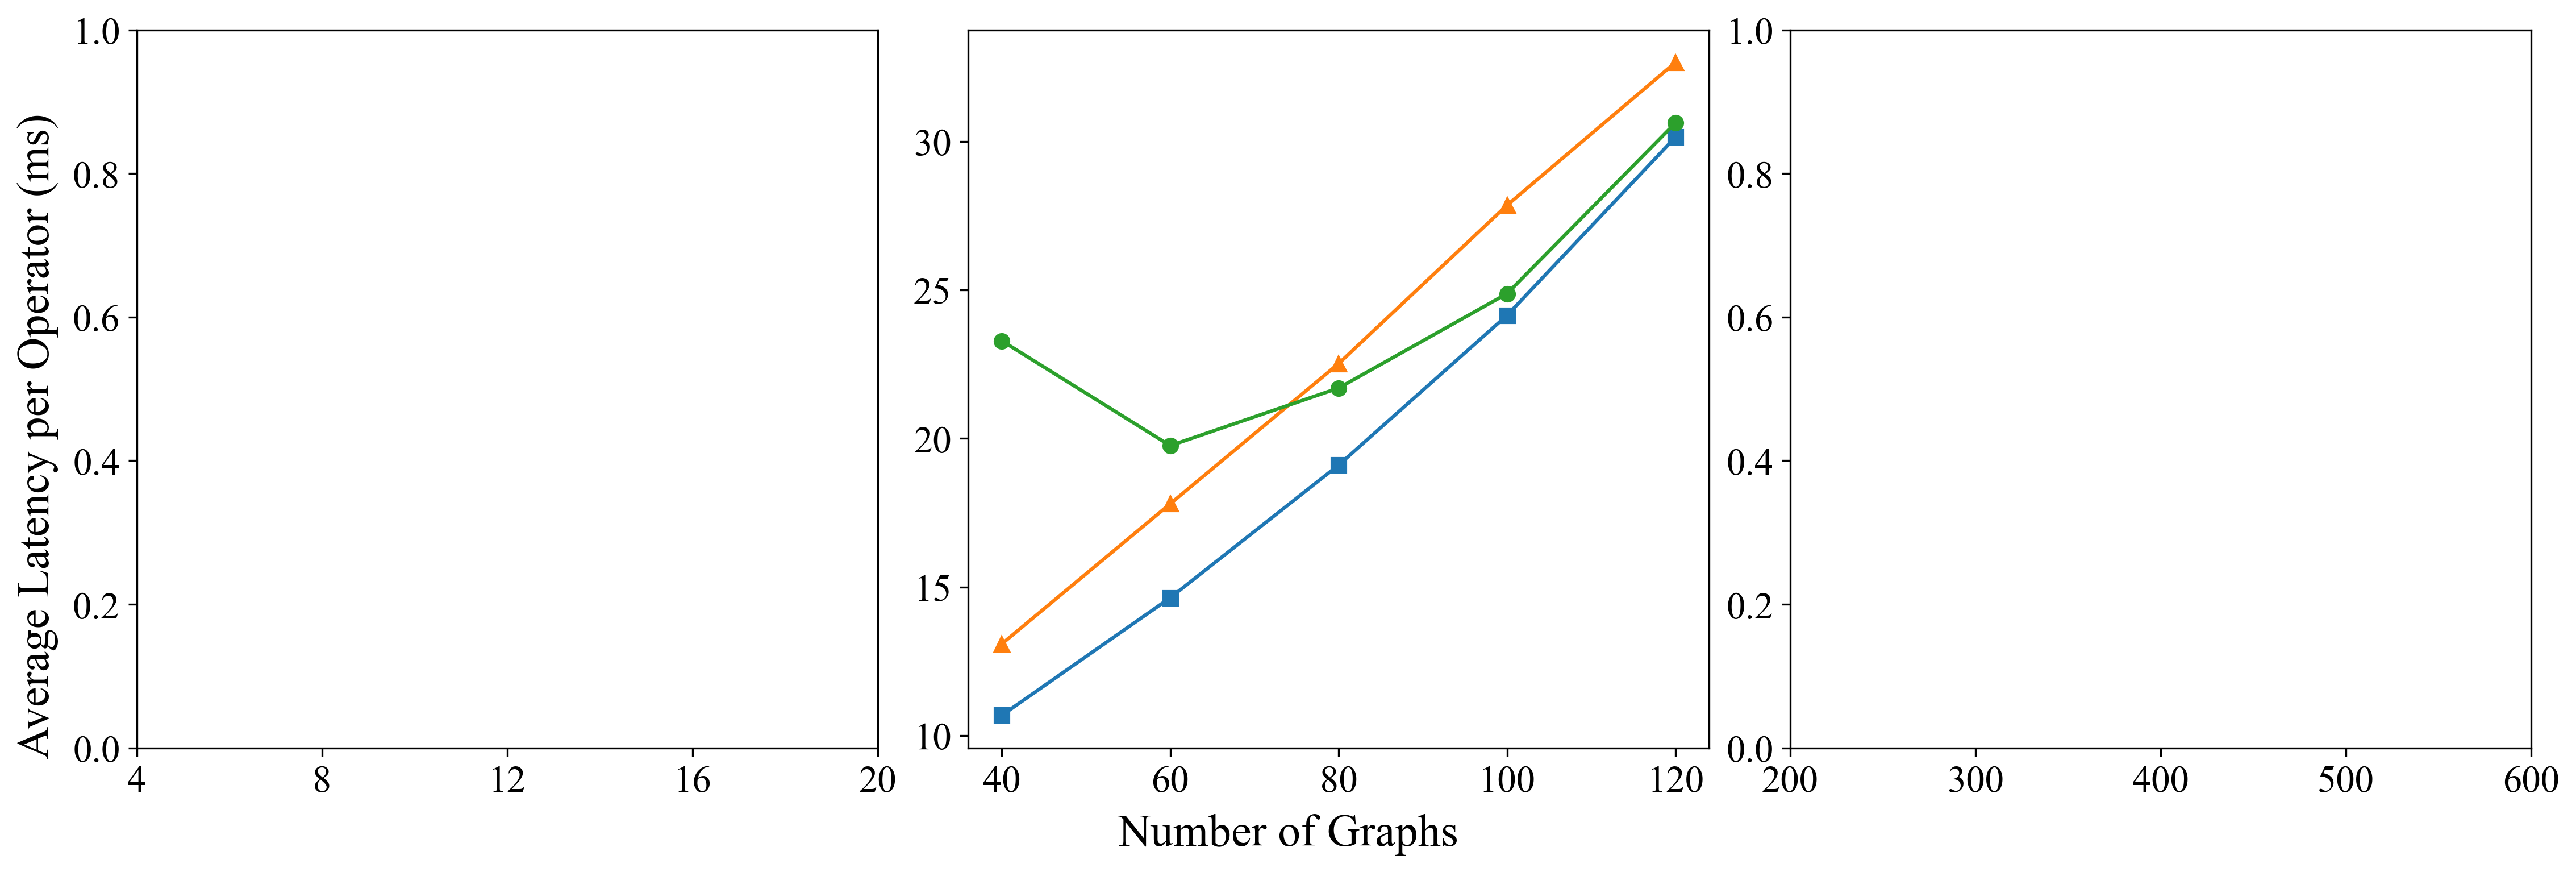

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=300, constrained_layout=True)
fig.supxlabel("Number of Graphs")
fig.supylabel("Average Latency per Operator (ms)")
axes[0].set_xticks([i for i in range(5)])
axes[0].set_xticklabels([4, 8, 12, 16, 20])
axes[1].set_xticks([i for i in range(5)])
axes[1].set_xticklabels([40, 60, 80, 100, 120])
axes[2].set_xticks([i for i in range(5)])
axes[2].set_xticklabels([200, 300, 400, 500, 600])
# axes[0].plot(f_lat, marker="s")
# axes[0].plot(ac_lat, marker="^")
# axes[0].plot(sbon_lat, marker="o")
axes[1].plot(f_lat2, marker="s")
axes[1].plot(ac_lat2, marker="^")
axes[1].plot(sbon_lat2, marker="o")
# axes[2].plot(f_lat3, marker="s")
# axes[2].plot(ac_lat3, marker="^")
plt.show()

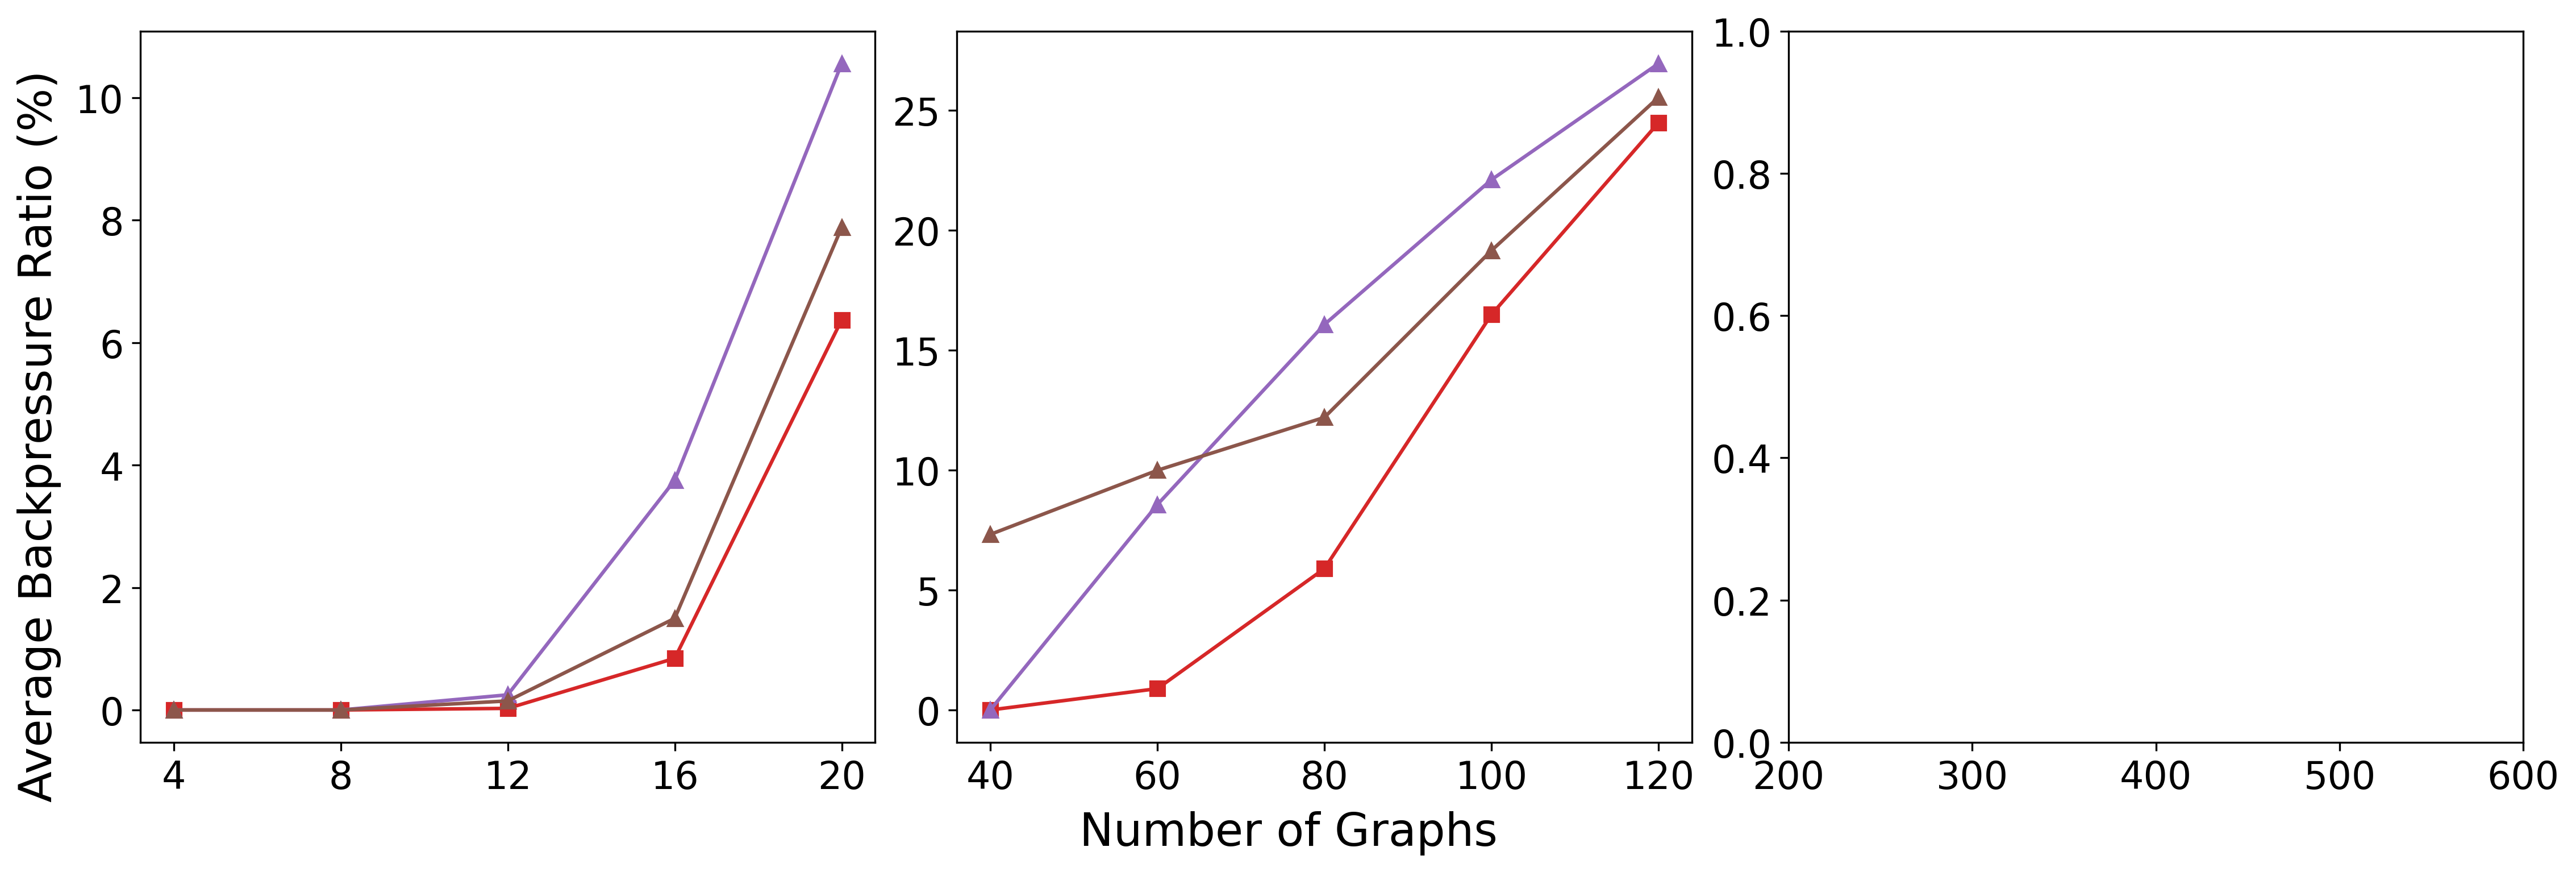

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=300, constrained_layout=True)
fig.supxlabel("Number of Graphs")
fig.supylabel("Average Backpressure Ratio (%)")
axes[0].set_xticks([i for i in range(5)])
axes[0].set_xticklabels([4, 8, 12, 16, 20])
axes[1].set_xticks([i for i in range(5)])
axes[1].set_xticklabels([40, 60, 80, 100, 120])
axes[2].set_xticks([i for i in range(5)])
axes[2].set_xticklabels([200, 300, 400, 500, 600])
axes[0].plot([i*100 for i in f_bp], marker="s", color="C3")
axes[0].plot([i*100 for i in ac_bp], marker="^", color="C4")
axes[0].plot([i*100 for i in sbon_bp], marker="^", color="C5")
axes[1].plot([i*100 for i in f_bp2], marker="s", color="C3")
axes[1].plot([i*100 for i in ac_bp2], marker="^", color="C4")
axes[1].plot([i*100 for i in sbon_bp2], marker="^", color="C5")
# axes[2].plot([i*100 for i in f_bp3], marker="s", color="C2")
# axes[2].plot([i*100 for i in ac_bp3], marker="^", color="C3")
plt.show()